

## Brayan Rodolfo Barajas Ochoa
**2170688**

In [ ]:
#@title 1. MONTAR EL DRIVE  (If you are in in colab){ display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/course-IA2')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/course-IA2


In [ ]:
#@title Load libraries { display-mode: "form" }
#@markdown Here is important to change to GPU  

import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
print(tf.__version__)

2.4.1


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Forecasting of IBM stock market index. Please load the dataset in data : 

```
datasets_8388_11883_IBM_2006-01-01_to_2018-01-01
```
 Use only one serie (High, for instance) to train and configurate RNN.

In [ ]:
data_IBM = pd.read_csv("data/datasets_8388_11883_IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
print(data_IBM.shape)
data_IBM.head(5)

(3020, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


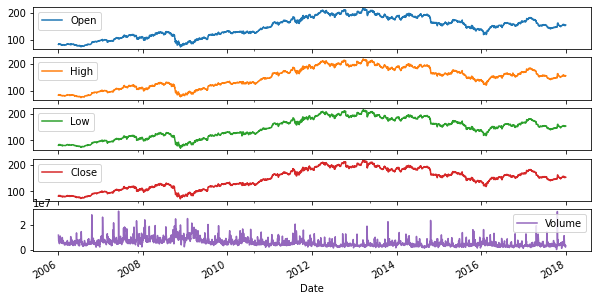

In [ ]:
data_IBM.plot(subplots=True, figsize=(10,5));

In [ ]:
#@title **code student** select for training all dataes until 2016
#@markdown we only we should to consider **HIGH**

#@markdown for test use 2017 data
set_entrenamiento = data_IBM[:'2016'].iloc[:,1:2]
set_test = data_IBM['2017'].iloc[:,1:2]
set_entrenamiento.head(3)

,High
Date,
2006-01-03,82.55
2006-01-04,82.50
2006-01-05,82.90


In [ ]:
#@title **code student** we typically should normalize data to obtain a better performance
#@markdown Use MaxMinscaler to scale trainin set betwwen [0-1]

#@markdown Reshape to (data,)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
set_test_escalado = sc.transform(set_test)
set_entrenamiento_escalado = set_entrenamiento_escalado.reshape(set_entrenamiento_escalado.shape[0])
set_test_escalado = set_test_escalado.reshape(set_test_escalado.shape[0])

In [ ]:
#@title **code** code (set_entrenamiento_escalado) 
#@markdown into a dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position, 
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    if (shuffle_buffer is not 0):
      print("shuffle")
      dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size=50
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=32, shuffle_buffer=100)

shuffle


In [ ]:
for i, (x,y) in enumerate(train_data):
  if i == 0:
    print('Number of samples in each batch: ', x.numpy().shape[0])
    print('Number of labels in each batch: ', y.numpy().shape[0])
    print('Number of features of each sample (temperature days): ', x.numpy().shape[1])
    print('---------------------')
    print('X_1 = \n', x.numpy()[1])
    print('\n')
    print('Y_1 = ', y.numpy()[1])

Number of samples in each batch:  32
Number of labels in each batch:  32
Number of features of each sample (temperature days):  50
---------------------
X_1 = 
 [0.07262609 0.07171034 0.07657087 0.07058326 0.0669907  0.06494787
 0.075796   0.07361229 0.06417301 0.05621302 0.05783319 0.05409975
 0.05431107 0.05515638 0.05543815 0.05677656 0.05846717 0.05388842
 0.04811214 0.04233587 0.04402649 0.0490279  0.04832347 0.05297267
 0.05614258 0.05290223 0.05325444 0.04909834 0.04994365 0.04797126
 0.05431107 0.05212736 0.04726684 0.04895745 0.04656241 0.04839391
 0.04416737 0.0485348  0.04719639 0.04825303 0.05395886 0.05663567
 0.05853762 0.05959425 0.06375035 0.06917442 0.06889265 0.06670893
 0.06910397 0.07783883]


Y_1 =  0.0756551141166526


In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense1 = tf.keras.layers.Dense(units=32,
                              activation=tf.keras.activations.relu,
                              name='dense_layer')
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(window_size)
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
x = dense1(x)
y = dense(x)
############################################################################

model_3 = tf.keras.Model(inputs=input_, outputs=y)
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
InputTransform (Lambda)      (None, 50, 1)             0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 50, 20)            440       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
dense_layer (Dense)          (None, 32)                672       
_________________________________________________________________
ouput_layer (Dense)          (None, 1)                 33        
Total params: 1,965
Trainable params: 1,965
Non-trainable params: 0
___________________________________________________________

Epoch 1/10
85/85 [==============================] - 7s 71ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.1228
Epoch 2/10
85/85 [==============================] - 6s 74ms/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0647
Epoch 3/10
85/85 [==============================] - 6s 69ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0745
Epoch 4/10
85/85 [==============================] - 6s 65ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0378
Epoch 5/10
85/85 [==============================] - 5s 63ms/step - loss: 8.2932e-04 - mse: 8.2932e-04 - mae: 0.0222
Epoch 6/10
85/85 [==============================] - 6s 66ms/step - loss: 5.7329e-04 - mse: 5.7329e-04 - mae: 0.0187
Epoch 7/10
85/85 [==============================] - 6s 76ms/step - loss: 6.3505e-04 - mse: 6.3505e-04 - mae: 0.0194
Epoch 8/10
85/85 [==============================] - 6s 74ms/step - loss: 5.0535e-04 - mse: 5.0535e-04 - mae: 0.0171
Epoch 9/10
85/85 [==============================] - 5s 62ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0

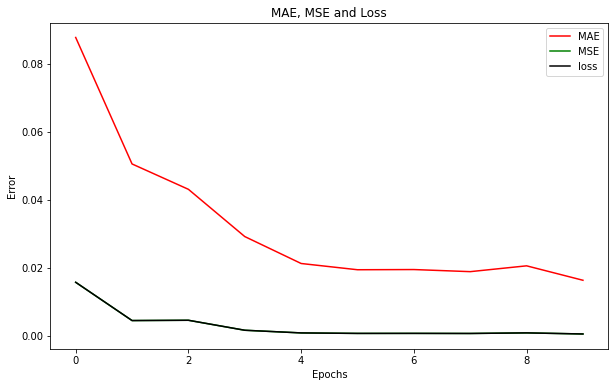

In [ ]:
#@title **code student** define model parameters
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


validation_init = int(len_n*0.7)
test_init = int(len_n*0.9)

model_3.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.8))  
# fit
history = model_3.fit(train_data,epochs=10,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

(2719, 1) (201, 1)
(2719, 1)


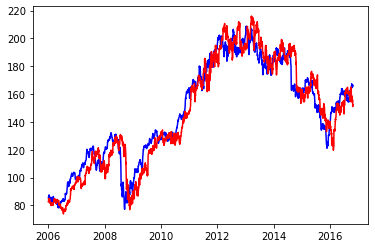

In [ ]:
#@title **code student** evaluate for training and test
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=32, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=32, shuffle_buffer=0)

train_IBM  = model_3.predict(train_data)
test_IBM  = model_3.predict(test_data)
print(train_IBM.shape, test_IBM.shape)


train_pred = sc.inverse_transform(train_IBM)

time = data_IBM.index.values
print(train_pred.shape)
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], train_pred[:,0],color='blue', label='predicted')
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], set_entrenamiento.values[0:train_pred.shape[0]], color='red', label='real')

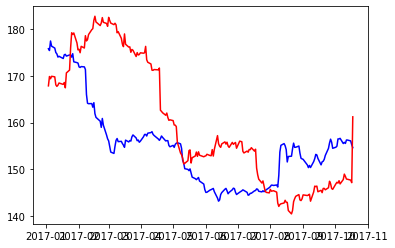

In [ ]:
#@title **code student** plot the test
pred_test = sc.inverse_transform(test_IBM)
plt.plot(set_test.index.values[0:test_IBM.shape[0]], pred_test[:,0],color='blue', label='predicted')
plt.plot(set_test.index.values[0:test_IBM.shape[0]], set_test.High.values[0:test_IBM.shape[0]],color='red', label='predicted')